This notebook trains a FNO on the generated burgers' equation data.

The 1D Burgers' equation is:
\begin{split}
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
\end{split}

In this notebook, the operator $G_0$ learned maps an initial condition to the solution at a later point in time:
\begin{split}
u(x, t_1) = G_0 (u(x, t_0))
\end{split}

This could be generalized as the following, assuming the process is Markovian and an autoregressive approach to timestepping can be taken:
\begin{split}
u(x, t+\Delta t) = G_0 (u(x, t))
\end{split}

In [52]:
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import optax
import matplotlib.pyplot as plt


from typing import Callable, List
from tqdm.autonotebook import tqdm

jax.default_device(jax.devices("cpu")[0])

In [3]:
# load data
mesh = jnp.load("mesh.npy")
tmesh = jnp.load("tmesh.npy")
solution_trajs = jnp.load("solution_trajectories.npy")

print(mesh.shape)
print(tmesh.shape, tmesh[1])
print(solution_trajs.shape)

(71,)
(301,) 0.01
(160, 301, 71)


In [40]:
# --> the training target is the "heat" distribution after a certain amount of time
dt = tmesh[1]
tstep = 0.3
jump = int(tstep / dt)

t_interests = [0, 0.5, 1, 1.5, 2, 2.5]
t_interests = [int(x/dt) for x in t_interests]

x_list_train = []
x_list_test = []
y_list_train = []
y_list_test = []
for t_interest in t_interests:
    x_list_train.append(solution_trajs[:120, t_interest])
    y_list_train.append(solution_trajs[:120, t_interest + jump])
    x_list_test.append(solution_trajs[120:, t_interest])
    y_list_test.append(solution_trajs[120:, t_interest + jump])

x_list_train = jnp.vstack(x_list_train)
x_list_test = jnp.vstack(x_list_test)

y_list_train = jnp.vstack(y_list_train)
y_list_test = jnp.vstack(y_list_test)

mesh_train = jnp.repeat(mesh[jnp.newaxis, jnp.newaxis, :], x_list_train.shape[0], axis=0)
mesh_test = jnp.repeat(mesh[jnp.newaxis, jnp.newaxis, :], x_list_test.shape[0], axis=0)

x_list_train.shape, y_list_train.shape, x_list_test.shape, y_list_test.shape, mesh_train.shape, mesh_test.shape

((720, 71), (720, 71), (240, 71), (240, 71), (720, 1, 71), (240, 1, 71))

In [41]:
x_train = jnp.concatenate((x_list_train[:, jnp.newaxis, :], mesh_train), axis=1)
x_test = jnp.concatenate((x_list_test[:, jnp.newaxis, :], mesh_test), axis=1)

x_train.shape, x_test.shape

((720, 2, 71), (240, 2, 71))

In [45]:
y_train = y_list_train[:, jnp.newaxis, :]
y_test = y_list_test[:, jnp.newaxis, :]

y_train.shape, y_test.shape

((720, 1, 71), (240, 1, 71))

In [50]:
class SpectralConv1d(eqx.Module):
    real_weights: jax.Array
    imag_weights: jax.Array
    in_channels: int
    out_channels: int
    modes: int

    def __init__(self, in_channels, out_channels, modes, *, key,):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes

        # the larger the transformation between channels, the smaller we can initialize weights
        scale = 1.0 / (in_channels * out_channels)

        real_key, imag_key = jax.random.split(key)
        self.real_weights = jax.random.uniform(
            real_key, 
            (in_channels, out_channels, modes), 
            minval=-scale, 
            maxval=+scale
        )
        self.imag_weights = jax.random.uniform(
            imag_key, 
            (in_channels, out_channels, modes), 
            minval=-scale, 
            maxval=+scale
        )
    
    def complex_mult1d(self, x_hat, w):
        # use einstein summation convention
        # x_hat is (in_channels, modes)
        # w is (in_channels, out_channels, modes)
        # desired output shape is (out_channels, modes)
        # einsum will automatically perform multiplication
        # and sum over the indicies that no longer appear in the output
        return jnp.einsum("iM, ioM -> oM", x_hat, w)

    def __call__(self, x):
        # normally the convention is (batch, channel, spatial)
        # equinox default, all networks are single batch
        channels, spatial_points = x.shape
        # this rfft batches over the channel dimension. 
        # it is a 1d real valued FFT that looks over the last dimension.
        # shape of x_hat will be (channels, spatial_points//2+1)
        x_hat = jnp.fft.rfft(x)
        # "filter" for desired modes
        # shape of x_hat_under_modes is (channels, self.modes)
        x_hat_under_modes = x_hat[:, :self.modes]
        weights = self.real_weights + 1j * self.imag_weights
        # shape of out_hat_under_modes is (out_channels, self.modes)
        out_hat_under_modes = self.complex_mult1d(x_hat_under_modes, weights)
        # shape of out_hat is (out_channels, spatial_points//2+1)
        out_hat = jnp.zeros((self.out_channels, x_hat.shape[-1]), dtype=x_hat.dtype)
        # jax does not allow array mutation
        # use the following to set indices of out_hat to relevant values from out_hat_under_modes
        out_hat = out_hat.at[:, :self.modes].set(out_hat_under_modes)
        # obtain output. inform the irfft about the number of spatial points used
        out = jnp.fft.irfft(out_hat, n=spatial_points)
        #
        return out

In [53]:
class FNOBlock1d(eqx.Module):
    spectral_conv: SpectralConv1d
    bypass_conv: eqx.nn.Conv1d
    activation: Callable

    def __init__(self, in_channels, out_channels, modes, activation, *, key):
        spectral_conv_key, bypass_conv_key = jax.random.split(key)
        self.spectral_conv = SpectralConv1d(in_channels, out_channels, modes, key=spectral_conv_key)
        # with kernel size of 1, this is just a feedforward layer (but possibly generalizable to 2d)
        self.bypass_conv = eqx.nn.Conv1d(in_channels, out_channels, kernel_size=1, key=bypass_conv_key)
        self.activation = activation
    
    def __call__(self, x):
        return self.activation(self.spectral_conv(x) + self.bypass_conv(x))

In [54]:
class FNO1d(eqx.Module):
    lifting: eqx.nn.Conv1d
    fno_blocks: List[FNOBlock1d]
    projection: eqx.nn.Conv1d

    def __init__(self, in_channels, out_channels, modes, width, activation, n_blocks:int=4, *, key):
        key, lifting_key = jax.random.split(key)
        self.lifting = eqx.nn.Conv1d(in_channels, width, 1, key=lifting_key)
        self.fno_blocks = []
        for i in range(n_blocks):
            key, subkey = jax.random.split(key)
            self.fno_blocks.append(FNOBlock1d(width, width, modes, activation, key=subkey))
        key, projection_key = jax.random.split(key)
        self.projection = eqx.nn.Conv1d(width, out_channels, 1, key=projection_key)
    
    def __call__(self, x):
        x = self.lifting(x)
        for fno_block in self.fno_blocks:
            x = fno_block(x)
        x = self.projection(x)
        return x

In [55]:
fno = FNO1d(
    2,  # input consists of state and mesh
    1,  # output is just state
    16, # modes
    64, # hidden channel dimension
    jax.nn.relu,
    key=jax.random.PRNGKey(0)
)

In [62]:
def fno_dataloader(dataset_x, dataset_y, batchsize:int=10, epoch:int=0):
    """Dataloader for FNO training. Uses functional paradigm like the rest of JAX.
    
    Args:
        dataset_x:
        dataset_y:
        batchsize (int): default batch size is 10
        epoch (int): used to seed JAX PRNG

    Yields:
        Tuple of training data and targets, of shape (batch size, NX)
    """
    key = jax.random.PRNGKey(epoch)
    NS = dataset_x.shape[0]
    MAXITR = NS // batchsize
    sarr = jax.random.permutation(key, jnp.arange(NS))
    for itr in range(MAXITR):
        group2yield = jnp.array(range(itr * batchsize, itr * batchsize + batchsize))
        ysarr = sarr[group2yield]
        yield (dataset_x[ysarr], dataset_y[ysarr])

In [63]:
for asdf, qwerty in fno_dataloader(x_train, y_train, batchsize=3, epoch=0):
    print(asdf.shape, qwerty.shape)
    break

(3, 2, 71) (3, 1, 71)


In [ ]:
def loss_fn(model, x, y,):
    # Equinox convention is that data does not have a prepended batch dimension like pytorch or tensorflow
    # use jax.vmap to allow batching
    y_pred = jax.vmap(model)(x)
    loss = jnp.mean(jnp.square(y_pred - y))  # MSE
    return loss


optimizer = optax.adam(3e-4)
opt_state = optimizer.init(eqx.filter(fno, eqx.is_array))


@eqx.filter_jit
def make_step(model, state, x, y):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(model, x, y)
    val_loss = loss_fn(model, x_test[..., :], y_test[..., :])
    updates, new_state = optimizer.update(grad, state, model)
    new_model = eqx.apply_updates(model, updates)
    return new_model, new_state, loss, val_loss

loss_history = []
val_loss_history = []

for epoch in tqdm(range(200)):
    for (batch_x, batch_y) in fno_dataloader(
            x_train[..., :],  # downsample spatial dimension
            y_train[..., :], 
            batchsize=50,
            epoch=epoch
    ):
        fno, opt_state, loss, val_loss = make_step(fno, opt_state, batch_x, batch_y)
        loss_history.append(loss)
        val_loss_history.append(val_loss)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [04:17<00:00,  1.29s/it]


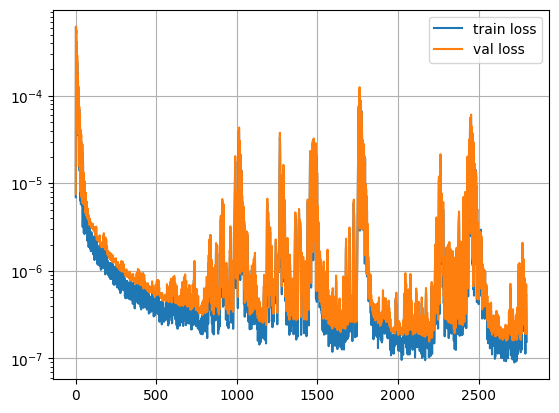

In [67]:
plt.plot(loss_history, label="train loss")
plt.plot(val_loss_history, label="val loss")
plt.legend()
plt.yscale("log")
plt.grid()

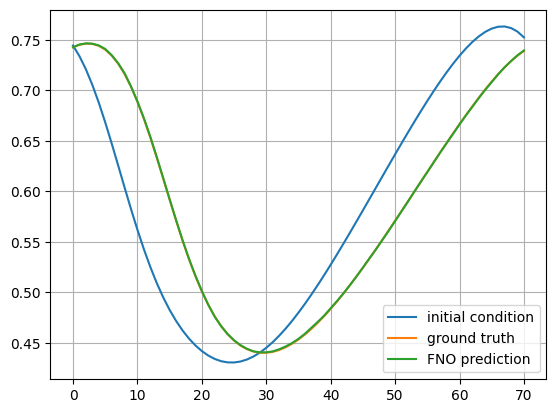

In [85]:
sample = 99
assert sample >=0 and sample < x_test.shape[0], "Sample out of range"
fno_pred = fno(x_test[sample, :, :])[0]

plt.plot(x_test[sample, 0, :], label="initial condition")
plt.plot(y_test[sample, 0, :], label="ground truth")
plt.plot(fno_pred, label="FNO prediction")
plt.legend()
plt.grid()

In [91]:
# Compute error as repordted in FNO paper
test_pred = jax.vmap(fno)(x_test)

def relative_l2_norm(pred, ref):
    diff_norm = jnp.linalg.norm(pred - ref)  # default is 2-norm
    ref_norm = jnp.linalg.norm(ref)
    return diff_norm / ref_norm

rel_l2_set = jax.vmap(relative_l2_norm)(test_pred, y_test)
rel_l2_set.mean(), rel_l2_set.std(), rel_l2_set.shape

(Array(0.00094101, dtype=float32), Array(0.00039373, dtype=float32), (240,))